# IR h5 file exploration 


This notebook aims to demonstrate the use of the h5 file containing the IR videos of the NTU-RGB-D dataset. 

In [1]:
%matplotlib notebook
import numpy as np
import h5py
import random
import os
import sys
import time

from matplotlib import animation
import matplotlib.pyplot as plt
# Moves back one folder to use module from src folder
sys.path.insert(0, os.getcwd() + '/../')

from play_skeleton import *
from src.utils.joints import *

h5_dataset_path = "/media/gnocchi/Seagate Backup Plus Drive/NTU-RGB-D/"
ir_dataset_file_name = "ir.h5"
log_file_name = "samples_names.txt"

## Randome sample

On our machine, it takes about 0.5s to fetch and decompress a given sample

In [2]:
# Sample names in a list (total of 56880 samples)
samples_names_list = [line.rstrip('\n') for line in open(h5_dataset_path + log_file_name)]

# Shuffle samples_names_list 
random.shuffle(samples_names_list)

# Take first random sample
sample_name = samples_names_list[0]

# Open dataset
ir_dataset = h5py.File(h5_dataset_path + ir_dataset_file_name, 'r')

# Get ir video shape (n_frames, 424, 512, 3) 
start = time.time()
ir_sample = ir_dataset[sample_name]["ir"][:]
stop = time.time()

print("It took : " + str(stop - start) + "s to fetch and decompress ir video")

It took : 0.531275749206543s to fetch and decompress ir video


## Playback video

<IPython.core.display.Javascript object>


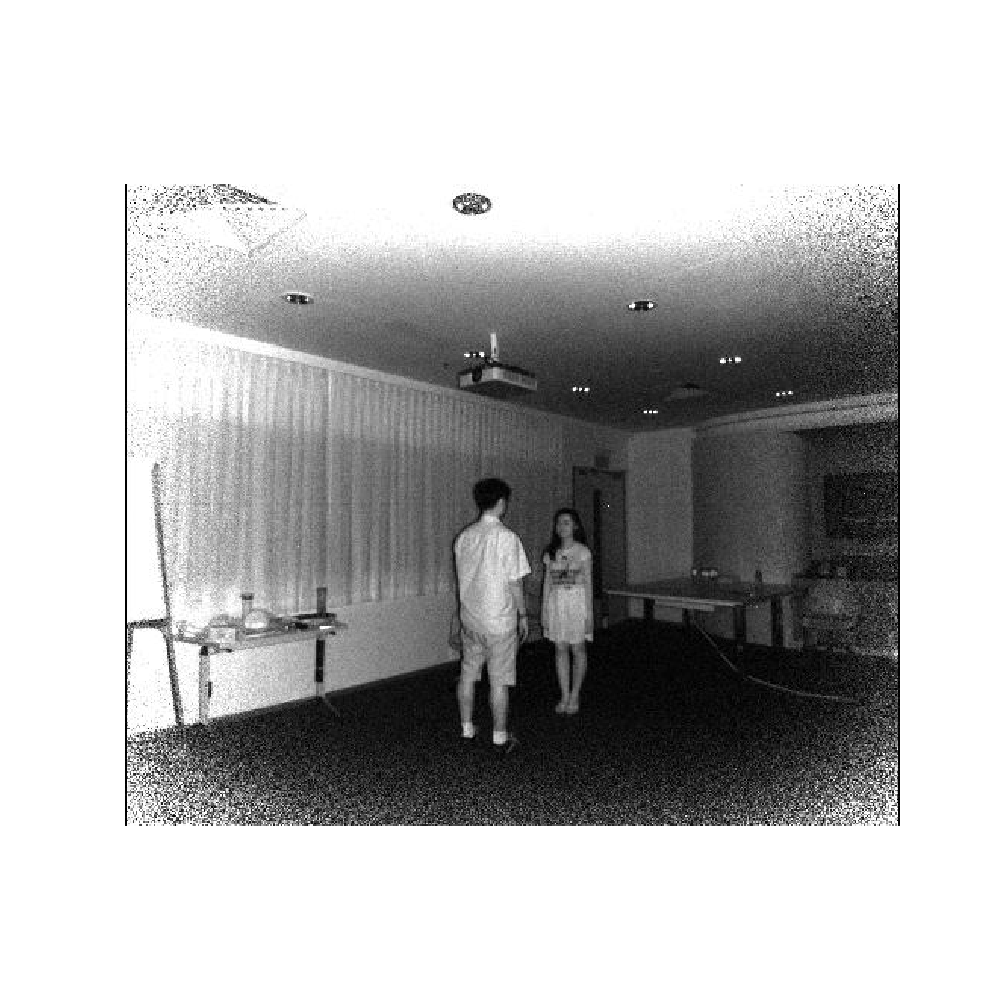

In [3]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

image = plt.imshow(ir_sample[0], interpolation='None', animated = True, cmap='gray')

plt.axis('off')


def videoAnimation(frame_index):
    image.set_data(ir_sample[frame_index])
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 1000 / 30, frames = ir_sample.shape[0], repeat = False)

## Filtering

Applying filters to remove noise and focus features

(424, 512)


<IPython.core.display.Javascript object>


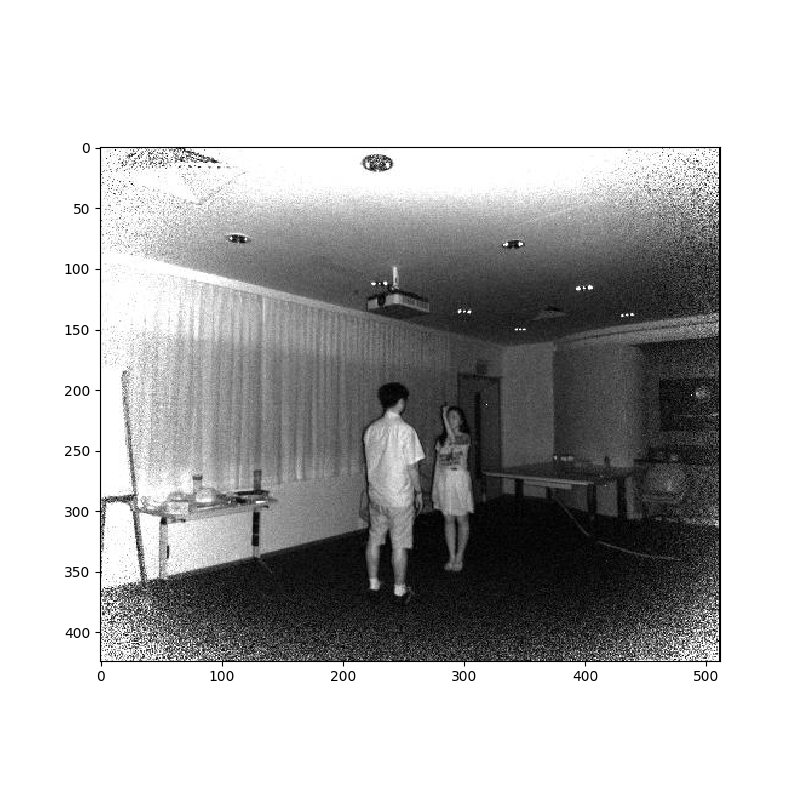

In [4]:
image = ir_sample[20]
print(image.shape)

f = plt.figure()
plt.imshow(image, cmap='gray')
f.set_size_inches(8,8)

### Median filter

<IPython.core.display.Javascript object>


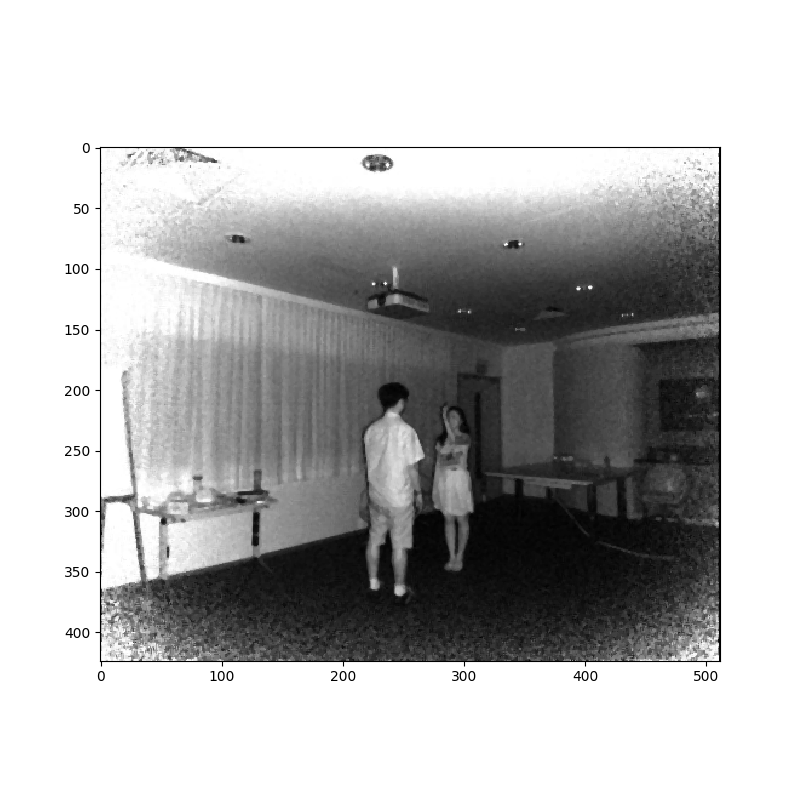

In [5]:
from scipy import ndimage

result = ndimage.median_filter(image[:, :], size=3)
f = plt.figure()
plt.imshow(result, cmap='gray')
f.set_size_inches(8,8)

### Exposure

In [6]:
from skimage import exposure

<IPython.core.display.Javascript object>


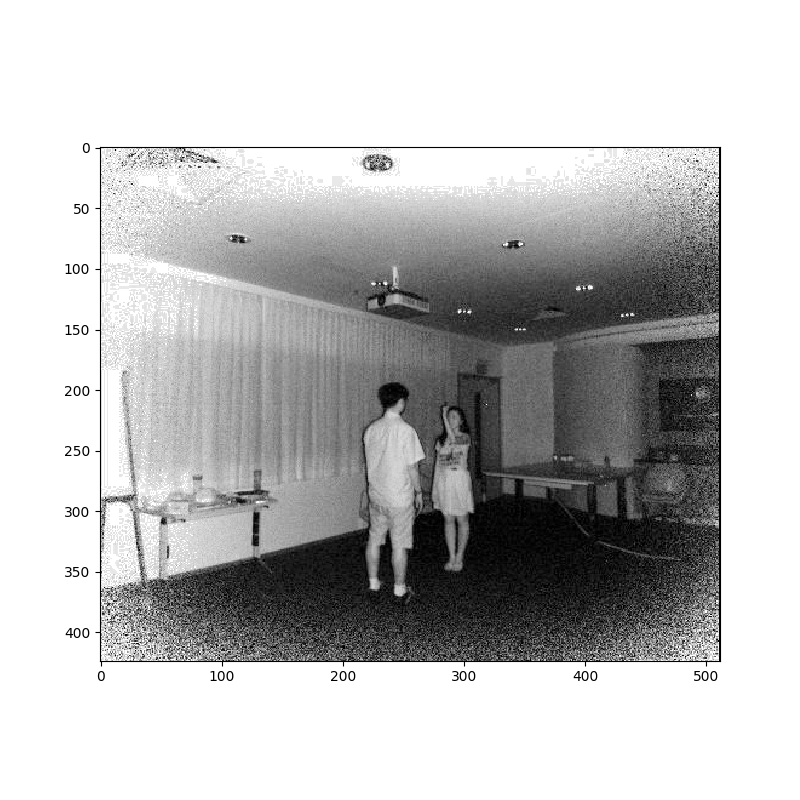

In [7]:
result = exposure.equalize_hist(image[:, :])
f = plt.figure()
plt.imshow(result, cmap='gray')
f.set_size_inches(8,8)